# NN back propagation（神经网络反向传播）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
import scipy.optimize as opt
from sklearn.metrics import classification_report

## Visualizing the data

In [2]:
def load_data(path, transpose=True):
    data = loadmat(path)
    X = data['X']
    y = data['y']
    y = y.reshape(y.shape[0])
    
    if transpose:
        X = np.array([im.reshape((20,20)).T.reshape(400) for im in X])
    return X, y

In [3]:
raw_x, raw_y = load_data('ex4data1.mat')
raw_x.shape, raw_y.shape

((5000, 400), (5000,))

In [4]:
def plot_100_image(X):
    sz = int(np.sqrt(X.shape[1]))
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
    sample_images = X[sample_idx, :]
    
    fig, axs = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, 
                            figsize=(8,8))
    for r in range(10):
        for c in range(10):
            axs[r, c].matshow(sample_images[10 * r + c].reshape((sz, sz)),
                              cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()    

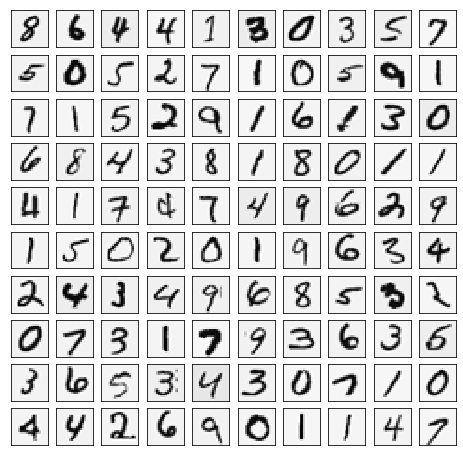

In [5]:
plot_100_image(raw_x)

## init data

In [6]:
X, y = load_data('ex4data1.mat', transpose=False)
X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
X.shape, y.shape

((5000, 401), (5000,))

In [7]:
y

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

In [8]:
def expend_y(y):
    '''
    expend 5000*1 -> 5000*10
    y=2 -> y=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    '''
    
    res = []
    for i in y:
        tmp = np.zeros(10)
        tmp[i-1] = 1
        res.append(tmp)
    return np.array(res)

    '''
    与expand_y(y)结果一致
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    y_onehot = encoder.fit_transform(y)
    y_onehot.shape 
    '''

In [9]:
y = expend_y(y)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [10]:
def load_weight(path):
    data = loadmat(path)
    return data['Theta1'], data['Theta2']

In [11]:
t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

In [12]:
def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))

In [13]:
def deserialize(seq):
    return seq[ : 25*401].reshape(25, 401), seq[25*401 : ].reshape(10, 26)

In [14]:
theta = serialize(t1, t2)
theta.shape

(10285,)

## feed forward
(400+1) -> (25+1)-> (10)

![](img/nn_model.png)

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [16]:
def feed_forward(theta, X):
    t1, t2 = deserialize(theta) # t1:(25, 401) t2:(10, 26)
    a1 = X # 5000*401
    
    z2 = a1 @ t1.T # 5000*25
    a2 = np.insert(sigmoid(z2), 0, np.ones(z2.shape[0]), axis=1) # 5000*26
    
    z3 = a2 @ t2.T # 5000*10
    h = sigmoid(z3) # 5000*10
    return a1, z2, a2, z3, h

In [17]:
h = feed_forward(theta, X)[-1]
h

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

## cost funciton

![](img/cost.png)

In [18]:
def cost(theta, X, y):
    h = feed_forward(theta, X)[-1]
    tmp = -y * np.log(h) - (1-y) * np.log(1-h)
    return tmp.sum() / y.shape[0]

In [19]:
cost(theta, X, y)

0.2876291651613189

## regularized cost function

![](img/regularized_cost.png)

In [20]:
def regularized_cost(theta, X, y, l=1):
    t1, t2 = deserialize(theta)
    m = X.shape[0]
    
    reg1 = np.power(t1[:, 1:], 2).sum() / (2 * m)
    reg2 = np.power(t2[:, 1:], 2).sum() / (2 * m)
    
    return cost(theta, X, y) + reg1 + reg2

In [21]:
regularized_cost(theta, X, y)

0.38376985909092365

## Back propagation

In [22]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [23]:
sigmoid_gradient(0)

0.25

![](img/gradient.png)

### 更新梯度

In [24]:
def gradient(theta, X, y):
    t1, t2 = deserialize(theta)
    m = X.shape[0]
    
    delta1 = np.zeros(t1.shape) # 25*401
    delta2 = np.zeros(t2.shape) # 10*26
    
    a1, z2, a2, z3, h = feed_forward(theta, X)
    
    for i in range(m):
        a1i = a1[i] # 1*401
        z2i = z2[i] # 1*25
        a2i = a2[i] # 1*26

        hi  = h[i]  # 1*10
        yi  = y[i]  # 1*10
        d3i = hi - yi # 1*10，输出层的误差
        
        z2i = np.insert(z2i, 0, np.ones(1))
        d2i = t2.T @ d3i * sigmoid_gradient(z2i) # 1*26 隐藏层的误差
        
        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)
    
    return serialize(delta1, delta2)

In [25]:
d1, d2 = deserialize(gradient(theta, X, y))
d1.shape, d2.shape

((25, 401), (10, 26))

![](img/regularized_gradient.jpg)

In [26]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta, X, y))
    delta1 /= m
    delta2 /= m
    
    t1, t2 = deserialize(theta)
    t1[:, 0] = 0
    t2[:, 0] = 0
    
    delta1 += l / m * t1
    delta2 += l / m * t2
    
    return serialize(delta1, delta2)

![](img/check_gradient.png)

In [27]:
def expand_array(arr):
    '''
    replicate array into matrix
    
    [1, 2, 3]
    
    [[1, 2, 3],
    [1, 2, 3],
    [1, 2, 3]]
    
    '''
    
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

### 梯度检查

In [38]:
def gradient_checking(theta, X, y, epsilon, regularized=False):
    m = len(theta)
    def a_numeric_grad(plus, minus, regularized=False):
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (epsilon*2)
        else:
            return (cost(plus, X, y) - cost(minus, X, y)) / (epsilon*2)
    
    theta_matrix = expand_array(theta)
    epsilon_matrix = np.identity(m) * epsilon # identity单位矩阵
    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix
    
    approx_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized) 
                            for i in range(m)])
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)
    diff = np.linalg.norm(approx_grad - analytic_grad) / np.linalg.norm(approx_grad + analytic_grad)
    
    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))

In [39]:
gradient_checking(theta, X, y, epsilon=0.0001, regularized=True) # 慢

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 4.368507964452962e-10



### 进行训练

In [30]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

In [31]:
def nn_training(theta, X, y):
    init_theta = random_init(len(theta))
    res = opt.minimize(fun=regularized_cost, x0 = init_theta,
                      args=(X, y, 1), method='TNC',
                      jac=regularized_gradient,
                      options={'maxiter': 400})
    return res

In [32]:
res = nn_training(theta, X, y) # 慢
res

     fun: 0.316877835391405
     jac: array([-1.24453866e-04,  1.23144499e-09,  8.46466802e-08, ...,
       -8.67755494e-05, -1.05034204e-04, -5.33202643e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 25
  status: 3
 success: False
       x: array([ 0.00000000e+00,  6.15722497e-06,  4.23233401e-04, ...,
       -2.55608484e-01,  2.25415318e+00,  3.59552422e-01])

In [33]:
final_theta = res.x
final_theta

array([ 0.00000000e+00,  6.15722497e-06,  4.23233401e-04, ...,
       -2.55608484e-01,  2.25415318e+00,  3.59552422e-01])

In [34]:
h

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

In [35]:
_, _, _, _, h = feed_forward(theta, X)
y_pred = np.argmax(h, axis=1) + 1
print(classification_report(raw_y, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       500
           2       0.98      0.97      0.97       500
           3       0.96      0.97      0.97       500
           4       0.97      0.96      0.96       500
           5       0.98      0.96      0.97       500
           6       0.97      0.99      0.98       500
           7       0.98      0.96      0.97       500
           8       0.96      0.98      0.97       500
           9       0.96      0.96      0.96       500
          10       0.98      0.99      0.98       500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



### 显示隐藏层

In [36]:
def plot_hidden_layer(theta):
    t1, t2 = deserialize(theta)
    hidden_layer = t1[:, 1:]
    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5,5))
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5*r+c].reshape((20,20)), 
                                  cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))            
    plt.show()

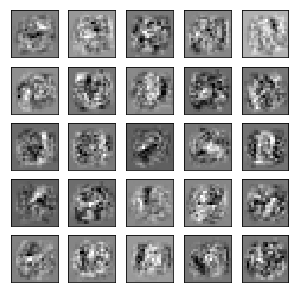

In [37]:
plot_hidden_layer(final_theta)